In [ ]:
"""
Three techniques:

1. Recurrent dropout — This is a specific, built-in way to use dropout to fight overfitting in recurrent layers.
2. Stacking recurrent layers — This increases the representational power of the network (at the cost of higher computational loads).
3. Bidirectional recurrent layers — These present the same information to a recurrent network in different ways, increasing
                                     accuracy and mitigating forgetting issues.
"""

In [1]:
import os
import numpy as np

data_dir = './data/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

# load data
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

# parse data to numpy array
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
print(float_data[0])

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551
[ 9.96520e+02 -8.02000e+00  2.65400e+02 -8.90000e+00  9.33000e+01
  3.33000e+00  3.11000e+00  2.20000e-01  1.94000e+00  3.12000e+00
  1.30775e+03  1.03000e+00  1.75000e+00  1.52300e+02]


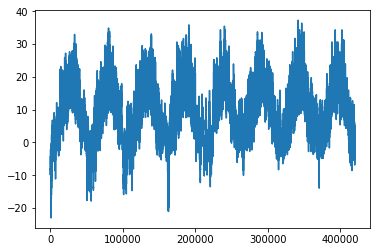

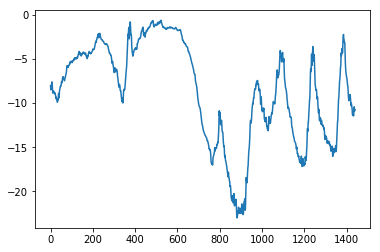

In [3]:
"""
Plotting the temperature timeseries
"""
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.show()

# first 10 days 
plt.plot(range(1440), temp[:1440])
plt.show()

In [4]:
"""
Prepare data

1. Preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so you don’t need to do
   any vectorization. But each timeseries in the data is on a different scale (for example, temperature is typically between -20 and +30,
   but atmospheric pressure, measured in mbar, is around 1,000). You’ll normalize each timeseries independently so that they all take
   small values on a similar scale.

2. Write a Python generator that takes the current array of float data and yields batches of data from the recent past, along with a target
   temperature in the future. Because the samples in the dataset are highly redundant (sample N and sample N + 1 will have most of their
   timesteps in common), it would be wasteful to explicitly allocate every sample. Instead, you’ll generate the samples on the fly
   using the original data.
"""

# normalize the data
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

"""
Generateor yielding timeseries samples and their targets

data           —   The original array of floating-point data, which you normalized above.
lookback       —   How many timesteps back the input data should go.
delay          —   How many timesteps in the future the target should be.
min/max_index  —   Indices in the data array that delimit which timesteps to draw from. This is useful for keeping a segment of the
                    data for validation and another for testing.
shuffle        —   Whether to shuffle the samples or draw them in chronological order.
batch_size     —   The number of samples per batch.
step           —   The period, in timesteps, at which you sample data.
"""

def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

# Preparing the training, validation, and test generators
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [ ]:
"""
A common-sense, non-machine-learning baseline

1. Before you start using black-box deep-learning models to solve the temperatureprediction problem, let’s try a simple, common-sense
   approach. It will serve as a sanity check, and it will establish a baseline that you’ll have to beat in order to demonstrate
   the usefulness of more-advanced machine-learning models. Such common-sense baselines can be useful when you’re approaching a new
   problem for which there is no known solution (yet).
   
2. A classic example is that of unbalanced classification tasks, where some classes are much more common than others. If your dataset
   contains 90% instances of class A and 10% instances of class B, then a common-sense approach to the classification task is to always
   predict “A” when presented with a new sample. Such a classifier is 90% accurate overall, and any learning-based approach should
   therefore beat this 90% score in order to demonstrate usefulness. Sometimes, such elementary baselines can prove surprisingly hard to beat.

3. A common-sense approach is to always predict that the temperature 24 hours from now will be equal to the temperature right now. Let’s
   evaluate this approach, using the mean absolute error (MAE) metric
"""
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

Epoch 1/20
500/500 [==============================] - 8s 16ms/step - loss: 1.2651 - val_loss: 0.6757
Epoch 2/20
500/500 [==============================] - 6s 12ms/step - loss: 0.4223 - val_loss: 0.3088
Epoch 3/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2910 - val_loss: 0.2973
Epoch 4/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2666 - val_loss: 0.3091
Epoch 5/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2535 - val_loss: 0.3091
Epoch 6/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2420 - val_loss: 0.3445
Epoch 7/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2372 - val_loss: 0.3164
Epoch 8/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2326 - val_loss: 0.3323
Epoch 9/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2271 - val_loss: 0.3453
Epoch 10/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2236 - val_lo

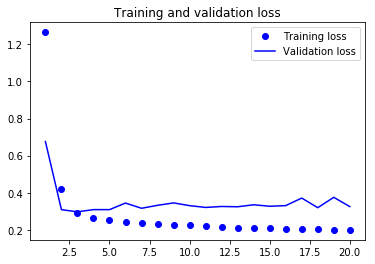

In [6]:
"""
A basic machine-learning approach

1. In the same way that it’s useful to establish a common-sense baseline before trying machine-learning approaches, it’s useful to try
   simple, cheap machine-learning models (such as small, densely connected networks) before looking into complicated and computationally
   expensive models such as RNNs. This is the best way to make sure any further complexity you throw at the problem is legitimate
   and delivers real benefits

2. When you’re looking for a solution with a space of complicated models, the simple, well-performing baseline may be unlearnable, even
   if it’s technically part of the hypothesis space. That is a pretty significant limitation of machine learning in general: unless the
   learning algorithm is hardcoded to look for a specific kind of simple model, parameter learning can sometimes fail to find a simple
   solution to a simple problem. 
"""
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop


model = Sequential()

model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Epoch 1/20
500/500 [==============================] - 120s 240ms/step - loss: 0.3048 - val_loss: 0.2788
Epoch 2/20
500/500 [==============================] - 119s 237ms/step - loss: 0.2851 - val_loss: 0.2648
Epoch 3/20
500/500 [==============================] - 119s 237ms/step - loss: 0.2787 - val_loss: 0.2641
Epoch 4/20
500/500 [==============================] - 119s 237ms/step - loss: 0.2739 - val_loss: 0.2618
Epoch 5/20
500/500 [==============================] - 119s 238ms/step - loss: 0.2676 - val_loss: 0.2627
Epoch 6/20
500/500 [==============================] - 119s 237ms/step - loss: 0.2632 - val_loss: 0.2679
Epoch 7/20
500/500 [==============================] - 119s 238ms/step - loss: 0.2582 - val_loss: 0.2665
Epoch 8/20
500/500 [==============================] - 119s 238ms/step - loss: 0.2541 - val_loss: 0.2686
Epoch 9/20
500/500 [==============================] - 119s 237ms/step - loss: 0.2483 - val_loss: 0.2732
Epoch 10/20
500/500 [==============================] - 119s 238m

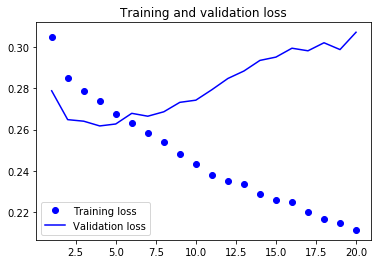

In [7]:
"""
A first recurrent baseline

The first fully connected approach didn’t do well, but that doesn’t mean machine learning isn’t applicable to this problem. The previous
approach first flattened the timeseries, which removed the notion of time from the input data. Let’s instead look at the data as what it is:
a sequence, where causality and order matter. You’ll try a recurrent-sequence processing model—it should be the perfect fit for such
sequence data, precisely because it exploits the temporal ordering of data points, unlike the first approach.
"""
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Epoch 1/40
 - 134s - loss: 0.3331 - val_loss: 0.2727
Epoch 2/40
 - 132s - loss: 0.3168 - val_loss: 0.2745
Epoch 3/40
 - 132s - loss: 0.3074 - val_loss: 0.2692
Epoch 4/40
 - 132s - loss: 0.3034 - val_loss: 0.2695
Epoch 5/40
 - 132s - loss: 0.3002 - val_loss: 0.2677
Epoch 6/40
 - 132s - loss: 0.2976 - val_loss: 0.2671
Epoch 7/40
 - 132s - loss: 0.2939 - val_loss: 0.2660
Epoch 8/40
 - 132s - loss: 0.2910 - val_loss: 0.2676
Epoch 9/40
 - 132s - loss: 0.2917 - val_loss: 0.2693
Epoch 10/40
 - 132s - loss: 0.2889 - val_loss: 0.2675
Epoch 11/40
 - 132s - loss: 0.2883 - val_loss: 0.2670
Epoch 12/40
 - 132s - loss: 0.2864 - val_loss: 0.2623
Epoch 13/40
 - 132s - loss: 0.2837 - val_loss: 0.2672
Epoch 14/40
 - 132s - loss: 0.2840 - val_loss: 0.2670
Epoch 15/40
 - 132s - loss: 0.2818 - val_loss: 0.2644
Epoch 16/40
 - 132s - loss: 0.2823 - val_loss: 0.2677
Epoch 17/40
 - 132s - loss: 0.2817 - val_loss: 0.2703
Epoch 18/40
 - 132s - loss: 0.2789 - val_loss: 0.2639
Epoch 19/40
 - 132s - loss: 0.2783 - 

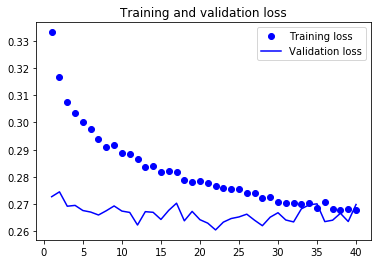

In [9]:
"""
Using recurrent dropout to fight overfitting


1. How to correctly apply dropout in recurrent networks isn’t a trivial question. It has long been known that applying dropout before
   a recurrent layer hinders learning rather than helping with regularization. In 2015, Yarin Gal, as part of his PhD thesis on Bayesian
   deep learning, determined the proper way to use dropout with a recurrent network: the same dropout mask (the same pattern of dropped
   units) should be applied at every timestep, instead of a dropout mask that varies randomly from timestep to timestep. What’s more,
   in order to regularize the representations formed by the recurrent gates of layers such as GRU and LSTM, a temporally constant dropout
   mask should be applied to the inner recurrent activations of the layer (a recurrent dropout mask).

2. Using the same dropout mask at every timestep allows the network to properly propagate its learning error through time; a temporally
   random dropout mask would disrupt this error signal and be harmful to the learning process.

3. Every recurrent layer in Keras has two dropout-related arguments: dropout, a float specifying the dropout rate for input units of the
   layer, and recurrent_dropout, specifying the dropout rate of the recurrent units. 
"""
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')


# Because networks being regularized with dropout always take longer to fully converge,
# you’ll train the network for twice as many epochs.
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40, # 
                              validation_data=val_gen,
                              validation_steps=val_steps,
                              verbose=2)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Epoch 1/40
 - 279s - loss: 0.3362 - val_loss: 0.2785
Epoch 2/40
 - 276s - loss: 0.3132 - val_loss: 0.2746
Epoch 3/40
 - 276s - loss: 0.3096 - val_loss: 0.2787
Epoch 4/40
 - 275s - loss: 0.3049 - val_loss: 0.2701
Epoch 5/40
 - 276s - loss: 0.3011 - val_loss: 0.2696
Epoch 6/40
 - 275s - loss: 0.2977 - val_loss: 0.2679
Epoch 7/40
 - 276s - loss: 0.2938 - val_loss: 0.2642
Epoch 8/40
 - 276s - loss: 0.2917 - val_loss: 0.2742
Epoch 9/40
 - 276s - loss: 0.2893 - val_loss: 0.2720
Epoch 10/40
 - 276s - loss: 0.2862 - val_loss: 0.2676
Epoch 11/40
 - 276s - loss: 0.2842 - val_loss: 0.2790
Epoch 12/40
 - 276s - loss: 0.2832 - val_loss: 0.2691
Epoch 13/40
 - 276s - loss: 0.2804 - val_loss: 0.2717
Epoch 14/40
 - 276s - loss: 0.2796 - val_loss: 0.2708
Epoch 15/40
 - 276s - loss: 0.2776 - val_loss: 0.2767
Epoch 16/40
 - 276s - loss: 0.2746 - val_loss: 0.2729
Epoch 17/40
 - 276s - loss: 0.2729 - val_loss: 0.2675
Epoch 18/40
 - 276s - loss: 0.2730 - val_loss: 0.2703
Epoch 19/40
 - 276s - loss: 0.2714 - 

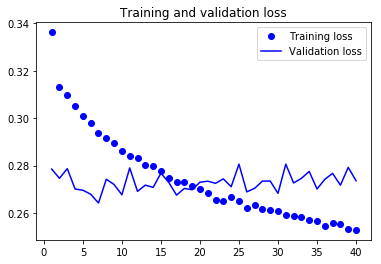

In [11]:
"""
Stacking recurrent layers

1. Because you’re no longer overfitting but seem to have hit a performance bottleneck, you should consider increasing the capacity of
   the network. Recall the description of the universal machine-learning workflow: it’s generally a good idea to increase the capacity of
   your network until overfitting becomes the primary obstacle. As long as you aren’t overfitting too badly, you’re likely under capacity.
   
2. Increasing network capacity is typically done by increasing the number of units in the layers or adding more layers. Recurrent layer
   stacking is a classic way to build more-powerful recurrent networks.

3. To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs
   (a 3D tensor) rather than their output at the last timestep. This is done by specifying return_sequences=True.

4. Because you’re still not overfitting too badly, you could safely increase the size of your layers in a quest for validation-loss
   improvement. This has a non-negligible computational cost, though. Moreover, adding a layer didn’t help by a significant factor,
   so you may be seeing diminishing returns from increasing network capacity at this point.
"""
model = Sequential()
model.add(layers.GRU(32,dropout=0.1, recurrent_dropout=0.5, return_sequences=True, input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps,
                              verbose=2)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
"""
Using bidirectional RNNs (1)

1. A bidirectional RNN is a common RNN variant that can offer greater performance than a regular RNN on certain tasks. It’s frequently
   used in natural-language processing—you could call it the Swiss Army knife of deep learning for natural-language processing.

2. RNNs are notably order dependent, or time dependent: they process the timesteps of their input sequences in order, and shuffling or
   reversing the timesteps can completely change the representations the RNN extracts from the sequence. This is precisely the reason
   they perform well on problems where order is meaningful, such as the temperature-forecasting problem. A bidirectional RNN exploits
   the order sensitivity of RNNs: it consists of using two regular RNNs, such as the GRU and LSTM layers you’re already familiar with,
   each of which processes the input sequence in one direction (chronologically and antichronologically), and then merging their
   representations. By processing a sequence both ways, a bidirectional RNN can catch patterns that may be overlooked by
   a unidirectional RNN.
"""

def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(float_data,
                                            lookback=lookback,
                                            delay=delay,
                                            min_index=0,
                                            max_index=200000,
                                            shuffle=True,
                                            step=step, 
                                            batch_size=batch_size)

val_gen_reverse = reverse_order_generator(float_data,
                                          lookback=lookback,
                                          delay=delay,
                                          min_index=200001,
                                          max_index=300000,
                                          step=step,
                                          batch_size=batch_size)



In [ ]:
"""
Using bidirectional RNNs (2)

The reversed-order GRU strongly underperforms even the common-sense baseline, indicating that in this case, chronological processing is
important to the success of your approach. This makes perfect sense: the underlying GRU layer will typically be better at remembering
the recent past than the distant past, and naturally the more recent weather data points are more predictive than older data points
for the problem (that’s what makes the common-sense baseline fairly strong). Thus the chronological version of the layer is bound to
outperform the reversed-order version. Importantly, this isn’t true for many other problems, including natural language: intuitively,
the importance of a word in understanding a sentence isn’t usually dependent on its position in the sentence.
"""

# reverse
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
"""
Using bidirectional RNNs (3)

You get performance nearly identical to that of the chronological-order LSTM. Remarkably, on such a text dataset, reversed-order processing
works just as well as chronological processing, confirming the hypothesis that, although word order does matter in understanding language,
which order you use isn’t crucial. Importantly, an RNN trained on reversed sequences will learn different representations than one trained
on the original sequences, much as you would have different mental models if time flowed backward in the real world—if you lived a life
where you died on your first day and were born on your last day. In machine learning, representations that are different yet useful are
always worth exploiting, and the more they differ, the better: they offer a new angle from which to look at your data, capturing aspects
of the data that were missed by other approaches, and thus they can help boost performance on a task. This is the intuition behind
ensembling.
"""

# Training imdb data using reversed sequences
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential


max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
"""
Using bidirectional RNNs (4)

It performs slightly better than the regular LSTM you tried in the previous section, achieving over 89% validation accuracy. It also seems
to overfit more quickly, which is unsurprising because a bidirectional layer has twice as many parameters as a chronological LSTM. With
some regularization, the bidirectional approach would likely be a strong performer on this task.
"""
model = Sequential()

model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
"""
Going even further

There are many other things you could try, in order to improve performance on the temperature-forecasting problem:
-- Adjust the number of units in each recurrent layer in the stacked setup. The current choices are largely arbitrary and thus
   probably suboptimal.
-- Adjust the learning rate used by the RMSprop optimizer.
-- Try using LSTM layers instead of GRU layers.
-- Try using a bigger densely connected regressor on top of the recurrent layers: that is, a bigger Dense layer or even
   a stack of Dense layers.
-- Don’t forget to eventually run the best-performing models (in terms of validation MAE) on the test set! Otherwise, you’ll develop
   architectures that are overfitting to the validation set.
"""
